In [1]:
from typing import List

import aesara.tensor as aet
import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import xarray
from scipy import linalg, spatial, special
from scipy.special import expit as logistic
from scipy.special import logit

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
arviz.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

## Data

In [3]:
polls = pd.read_csv(
    "../../data/polls_1st_round/tour1_complet_unitedfl.csv",
    index_col=0,
    parse_dates=["dateelection", "date"],
)
polls = (
    polls[(polls.dateelection == "2017-04-23") & (polls.date >= "2017-01")]
    .drop(
        [
            "type",
            "dateelection",
            "abstention",
            "undecided",
        ],
        axis=1,
    )
    .set_index(["date", "sondage", "samplesize"])
    .sort_index()
)

In [4]:
# Note: no green party here
COORDS = {
    "parties": ["farleft", "left", "center", "right", "farright"],
    "parties_complete": [
        "farleft",
        "left",
        "center",
        "right",
        "farright",
        "other",
    ],
}

In [5]:
# compute "other" category
polls = polls.rename(
    columns={col: col.split("nb")[1] for col in polls if col.startswith("nb")}
)[COORDS["parties"]]
polls["other"] = 100 - polls.sum(1)
polls = polls.reset_index()

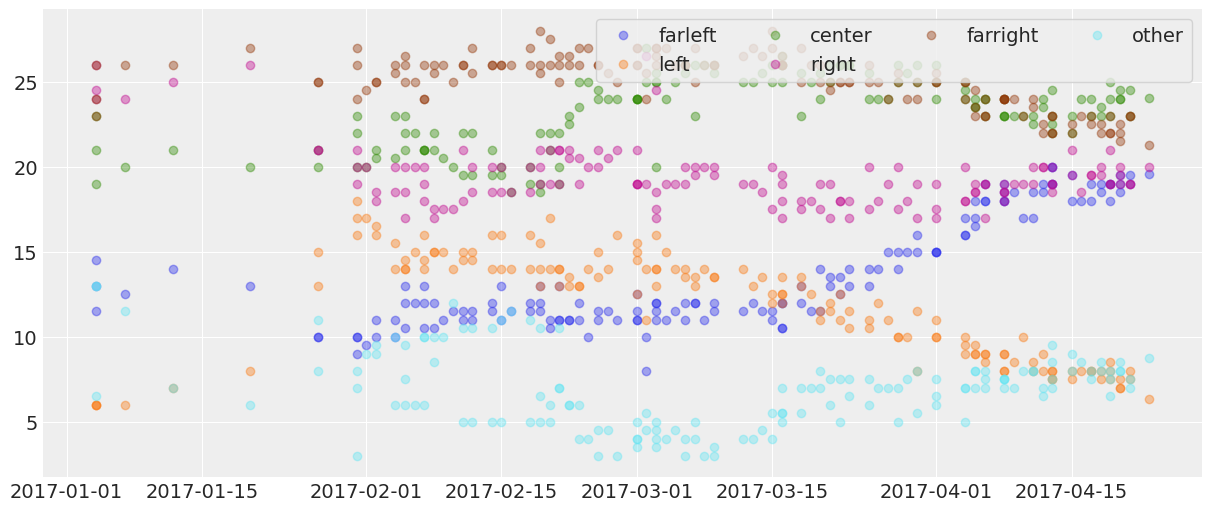

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
for p in COORDS["parties_complete"]:
    ax.plot(polls["date"], polls[p], "o", label=p, alpha=0.4)
ax.legend(ncol=4, frameon=True, loc="upper right");

In [7]:
# isolate results
results = polls[polls.sondage == "result"]
polls = polls[polls.sondage != "result"].set_index(["date", "sondage"])

In [8]:
# cast as multinomial obs
polls[COORDS["parties_complete"]] = (
    (polls[COORDS["parties_complete"]] / 100)
    .mul(polls["samplesize"], axis=0)
    .round()
    .fillna(0)
    .astype(int)
)
polls["samplesize"] = polls[COORDS["parties_complete"]].sum(1)
polls = polls.reset_index()
polls

date sondage  samplesize  farleft  left  center  right  farright  \
0   2017-01-04   Elabe         996      144    60     229    259       239   
1   2017-01-04   Elabe         995      129    60     209    239       229   
2   2017-01-04    Ifop        1472      169    88     280    361       383   
3   2017-01-07     BVA         946      118    57     189    227       246   
4   2017-01-12   Ipsos       15919     2229  1114    3343   3980      4139   
..         ...     ...         ...      ...   ...     ...    ...       ...   
139 2017-04-20   Elabe        1196      233    84     287    239       257   
140 2017-04-20    Ifop        1901      352   133     466    370       428   
141 2017-04-20   Ipsos        1400      266   105     336    266       308   
142 2017-04-21     BVA        1134      221    91     261    215       261   
143 2017-04-21   Odoxa         667      127    50     163    127       153   

     other  
0       65  
1      129  
2      191  
3      109  
4     1114  
..     ...  
139     96  
140    152  
141    119  
142     85  
143     47  

[144 rows x 9 columns]

In [9]:
ELECTION_DAY = pd.to_datetime("2017-04-23")
# TEST_CUTOFF = ELECTION_DAY - pd.Timedelta(1, "W")
TEST_CUTOFF = ELECTION_DAY - pd.Timedelta(2, "D")
WHOLE_TIMELINE = pd.date_range(polls.date[0], ELECTION_DAY, freq="D")
polls_train = polls[polls.date <= TEST_CUTOFF]
polls_test = polls[polls.date > TEST_CUTOFF]

In [10]:
def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date"""

    reference_time = timelist[0]
    t = (timelist - reference_time) / np.timedelta64(1, "D")

    return np.asarray(t)

## GP approximation

In [11]:
def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)

    return np.eye(N) - 2 * np.outer(v, v)

In [12]:
def make_centered_gp_eigendecomp(
    time: np.ndarray,
    lengthscales: List[float],
    variance_limit: float = 0.95,
    metric: str = "euclidean",
    zerosum: bool = False,
):
    """
    Decompose the GP into eigen values and eigen vectors.

    Parameters
    ----------
    time: np.ndarray
        Array containing the time points of observations.
    lengthscales: List[float]
        Length scale parameter of the GP. Set in the ``config`` dictionary.
    variance_limit: float, defaults to 0.95
        Controls how many of the eigen vectors of the GP are used. So, if
        ``variance_limit=1``, all eigen vectors are used.
    metric: str, defaults to "euclidean"
        Experimental. Used to estimate the distance between ranges and rows.
    zerosum: bool, default=False
        Constrain all basis functions to sum(basis) = 0.

    Notes
    -----
    Makes sure that the GP effect sums to zero across plots of each field.
    """

    ## Construct covariance matrix
    X = time[:, None]
    X_norm = X / np.array(lengthscales)
    dists = spatial.distance.cdist(X_norm, X_norm, metric=metric)
    cov = np.exp(-(dists ** 2) / 2)

    if zerosum:
        Q = make_sum_zero_hh(len(cov))
        D = np.eye(len(cov))
        D[0, 0] = 0

        # 1) Transform the covariance matrix so that the first entry
        # is the mean: A = Q @ cov @ Q.T
        # 2) Project onto the subspace without the mean: B = D @ A @ D
        # 3) Transform the result back to the original space: Q.T @ B @ Q
        cov = Q.T @ D @ Q @ cov @ Q.T @ D @ Q

    vals, vecs = linalg.eigh(cov)
    n_eigs = ((vals[::-1].cumsum() / vals.sum()) > variance_limit).nonzero()[0][0]

    return vecs[:, -n_eigs:] * np.sqrt(vals[-n_eigs:])

In [13]:
observed_days_idx = dates_to_idx(polls_train.date).astype(int)
estimated_days = dates_to_idx(WHOLE_TIMELINE).astype(int)
estimated_weeks_idx = WHOLE_TIMELINE.isocalendar().week.to_numpy().astype("int64") - 1
estimated_weeks = np.unique(estimated_weeks_idx)
pollster_id, pollsters = polls_train["sondage"].factorize(sort=True)

In [31]:
gp_day = make_centered_gp_eigendecomp(
    estimated_days,
    lengthscales=3.0,
    variance_limit=0.99
)
gp_week = make_centered_gp_eigendecomp(
    estimated_weeks,
    lengthscales=3.0,
    variance_limit=0.99
)

In [32]:
COORDS["pollsters"] = pollsters
COORDS["observed_days"] = polls_train.date
COORDS["estimated_days"] = WHOLE_TIMELINE
COORDS["estimated_weeks"] = estimated_weeks
COORDS["gp_day"] = pd.RangeIndex(gp_day.shape[-1])
COORDS["gp_week"] = pd.RangeIndex(gp_week.shape[-1])
COORDS["observations"] = polls_train.set_index(["date", "sondage", "samplesize"]).index

In [33]:
COORDS["estimated_weeks"]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [34]:
gp_day.shape, gp_week.shape

((110, 30), (16, 5))

In [35]:
estimated_weeks.shape, estimated_days.shape

((16,), (110,))

In [86]:
WHOLE_TIMELINE.isocalendar().week.to_numpy().astype("int64") - 1

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15])

# Note: doesn't reassign green party
mean_prior_p = (
    arviz.from_netcdf("fundamentals_preds.nc")
    .posterior.mean(("samples", "regions"))
    .sel(parties_complete=COORDS["parties_complete"])["x"]
    .data
)
prior_cum_p = np.cumsum(mean_prior_p)
prior_logit_p = logit(prior_cum_p)[:-1]

    n_cutpoints = len(COORDS["parties"])
    cut_base = pm.Normal("cut_base", mu=-1, sigma=3)
    cut_diffs = pm.HalfNormal("cut_diffs", sigma=2 / n_cutpoints, shape=n_cutpoints - 1)

    cutpoints = pm.Deterministic(
        "cutpoints",
        aet.concatenate([[cut_base], cut_base + cut_diffs.cumsum()]),
        dims="parties",
    )
    
    initval = np.tile(
        np.arange(len(COORDS["parties"])) - 2.5, reps=(len(COORDS["regions"]), 1)
    )
    cutpoints = pm.Normal(
        "cutpoints",
        mu=initval,
        sigma=3.0,
        initval=initval,
        transform=pm.distributions.transforms.ordered,
        dims=("regions", "parties"),
    )

In [89]:
with pm.Model(coords=COORDS) as m_all:
    n_parties = len(COORDS["parties"])
    intercept_base = pm.Normal("intercept_base", mu=-1, sigma=1)
    intercept_diffs = pm.HalfNormal(
        "intercept_diffs", sigma=2 / n_parties, shape=n_parties - 1
    )
    intercepts = pm.Deterministic(
        "intercepts",
        aet.concatenate([[intercept_base], intercept_base + intercept_diffs.cumsum()]),
        dims="parties",
    )
    #    intercepts = pm.Normal(
    #       "intercepts",
    #      mu=prior_logit_p,
    #     sigma=0.5,
    #    initval=prior_logit_p,
    #   transform=pm.distributions.transforms.ordered,
    #  dims="parties",
    # )

    trend_base = pm.Normal("trend_base", mu=-1, sigma=0.25)
    trend_diffs = pm.HalfNormal("trend_diffs", sigma=1 / n_parties, shape=n_parties - 1)
    trends = pm.Deterministic(
        "long_term_trends",
        aet.concatenate([[trend_base], trend_base + trend_diffs.cumsum()]),
        dims="parties",
    )

    gps_days = []
    gps_weeks = []
    for p in COORDS["parties"]:
        sd_d = pm.HalfNormal(f"day_weight_{p}", 0.25)
        sd_w = pm.HalfNormal(f"week_weight_{p}", 0.25)

        coefs_d = pm.Normal(f"day_coefs_{p}", dims="gp_day")
        coefs_w = pm.Normal(f"week_coefs_{p}", dims="gp_week")

        gp_d = aet.dot(gp_day, sd_d * coefs_d)
        pm.Deterministic(f"day_effect_{p}", gp_d, dims="estimated_days")
        gps_days.append(gp_d)

        gp_w = aet.dot(gp_week, sd_w * coefs_w)
        pm.Deterministic(f"week_effect_{p}", gp_w, dims="estimated_weeks")
        gps_weeks.append(gp_w)

    ordered_gps_days = pm.Deterministic(
        "ordered_gps_days",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps_days).T), axis=-1)),
        dims=("estimated_days", "parties"),
    )
    ordered_gps_weeks = pm.Deterministic(
        "ordered_gps_weeks",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps_weeks).T), axis=-1)),
        dims=("estimated_weeks", "parties"),
    )

    t = pm.Data("t", estimated_days / estimated_days.max(), dims="estimated_days")
    cutpoints = pm.Deterministic(
        "cutpoints",
        intercepts
        + aet.dot(t[:, None], trends[None, :])
        + ordered_gps_days
        + ordered_gps_weeks[estimated_weeks_idx],
        dims=("estimated_days", "parties"),
    )

    bias = pm.Normal("bias", 0, 0.25, dims="pollsters")

    pm.OrderedMultinomial(
        "results",
        eta=bias[pollster_id],
        cutpoints=cutpoints[observed_days_idx],
        n=polls_train["samplesize"].values,
        observed=polls_train[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

In [88]:
with m_all:
    trace_all = pm.sample(
        random_seed=RANDOM_SEED,
        #        tune=2000,
        #       target_accept=0.95,
        idata_kwargs=dict(
            dims={"results_probs": ["observed_days", "parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_base, intercept_diffs, trend_base, trend_diffs, day_weight_farleft, week_weight_farleft, day_coefs_farleft, week_coefs_farleft, day_weight_left, week_weight_left, day_coefs_left, week_coefs_left, day_weight_center, week_weight_center, day_coefs_center, week_coefs_center, day_weight_right, week_weight_right, day_coefs_right, week_coefs_right, day_weight_farright, week_weight_farright, day_coefs_farright, week_coefs_farright, bias]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 368 seconds.


0, dim: observations, 144 =? 144


There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
There were 296 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [36]:
with pm.Model(coords=COORDS) as m_gp:
    gps_days = []
    gps_weeks = []
    for p in COORDS["parties"]:
        sd_d = pm.HalfNormal(f"day_weight_{p}", 0.25)
        sd_w = pm.HalfNormal(f"week_weight_{p}", 0.25)

        coefs_d = pm.Normal(f"day_coefs_{p}", dims="gp_day")
        coefs_w = pm.Normal(f"week_coefs_{p}", dims="gp_week")

        gp_d = aet.dot(gp_day, sd_d * coefs_d)
        pm.Deterministic(f"day_effect_{p}", gp_d, dims="estimated_days")
        gps_days.append(gp_d)

        gp_w = aet.dot(gp_week, sd_w * coefs_w)
        pm.Deterministic(f"week_effect_{p}", gp_w, dims="estimated_weeks")
        gps_weeks.append(gp_w)

    ordered_gps_days = pm.Deterministic(
        "ordered_gps_days",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps_days).T), axis=-1)),
        dims=("estimated_days", "parties"),
    )
    ordered_gps_weeks = pm.Deterministic(
        "ordered_gps_weeks",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps_weeks).T), axis=-1)),
        dims=("estimated_weeks", "parties"),
    )

    cutpoints = pm.Deterministic(
        "cutpoints",
        ordered_gps_days + ordered_gps_weeks[estimated_weeks_idx],
        dims=("estimated_days", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[observed_days_idx],
        n=polls_train["samplesize"].values,
        observed=polls_train[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )
    
    trace_gp = pm.sample(
        idata_kwargs=dict(
            dims={"results_probs": ["observed_days", "parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [day_weight_farleft, week_weight_farleft, day_coefs_farleft, week_coefs_farleft, day_weight_left, week_weight_left, day_coefs_left, week_coefs_left, day_weight_center, week_weight_center, day_coefs_center, week_coefs_center, day_weight_right, week_weight_right, day_coefs_right, week_coefs_right, day_weight_farright, week_weight_farright, day_coefs_farright, week_coefs_farright]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 296 seconds.


0, dim: observations, 144 =? 144


There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [38]:
gp_basis = make_centered_gp_eigendecomp(
    estimated_days,
    lengthscales=3.0,
)

In [39]:
COORDS["gp_basis"] = pd.RangeIndex(gp_basis.shape[-1])

In [42]:
with pm.Model(coords=COORDS) as m_trend_eta:
    n_parties = len(COORDS["parties"])
#    intercept_base = pm.Normal("intercept_base", mu=-1, sigma=3)
 #   intercept_diffs = pm.HalfNormal(
  #      "intercept_diffs", sigma=2 / n_parties, shape=n_parties - 1
   # )
    #intercepts = pm.Deterministic(
     #   "intercepts",
      #  aet.concatenate([[intercept_base], intercept_base + intercept_diffs.cumsum()]),
       # dims="parties",
    #)

    trend = pm.Normal("long_term_trends")  # , dims="parties")
    t = pm.Data("t", observed_days_idx / observed_days_idx.max(), dims="observations")
    eta = pm.Deterministic("eta", trend * t, dims="observations")

    gps = []
    for p in COORDS["parties"]:

        sd = pm.HalfNormal(f"time_weight_{p}", 0.5)
        coefs = pm.Normal(f"time_coefs_{p}", dims="gp_basis")
        gp_party = aet.dot(gp_basis, sd * coefs)

        gps.append(gp_party)
        pm.Deterministic(f"time_effect_{p}", gp_party, dims="estimated_days")

    ordered_gps = pm.Deterministic(
        "ordered_gps",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps).T), axis=-1)),
        dims=("estimated_days", "parties"),
    )
    cutpoints = pm.Deterministic(
        "cutpoints",
        ordered_gps,
        dims=("estimated_days", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=eta,
        cutpoints=cutpoints[observed_days_idx],
        n=polls["samplesize"].values,
        observed=polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_trend_eta = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observed_days", "parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [long_term_trends, time_weight_farleft, time_coefs_farleft, time_weight_left, time_coefs_left, time_weight_center, time_coefs_center, time_weight_right, time_coefs_right, time_weight_farright, time_coefs_farright]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 245 seconds.


0, dim: observations, 144 =? 144


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [51]:
with pm.Model(coords=COORDS) as m_trend_gp:
    n_parties = len(COORDS["parties"])
    trend_base = pm.Normal("trend_base", mu=-1, sigma=0.25)
    trend_diffs = pm.HalfNormal("trend_diffs", sigma=1 / n_parties, shape=n_parties - 1)
    trends = pm.Deterministic(
        "long_term_trends",
        aet.concatenate([[trend_base], trend_base + trend_diffs.cumsum()]),
        dims="parties",
    )
    
    gps = []
    for p in COORDS["parties"]:

        sd = pm.HalfNormal(f"time_weight_{p}", 0.5)
        coefs = pm.Normal(f"time_coefs_{p}", dims="gp_basis")
        gp_party = aet.dot(gp_basis, sd * coefs)

        gps.append(gp_party)
        pm.Deterministic(f"time_effect_{p}", gp_party, dims="estimated_days")

    ordered_gps = pm.Deterministic(
        "ordered_gps",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps).T), axis=-1)),
        dims=("estimated_days", "parties"),
    )

    t = pm.Data("t", estimated_days / estimated_days.max(), dims="estimated_days")
    cutpoints = pm.Deterministic(
        "cutpoints",
        aet.dot(t[:, None], trends[None, :]) + ordered_gps,
        dims=("estimated_days", "parties"),
    )

#    bias = pm.Normal("bias", 0, 0.25, dims="pollsters")

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[observed_days_idx],
        n=polls_train["samplesize"].values,
        observed=polls_train[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )
    
    trace_trend_gp = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observed_days", "parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [trend_base, trend_diffs, time_weight_farleft, time_coefs_farleft, time_weight_left, time_coefs_left, time_weight_center, time_coefs_center, time_weight_right, time_coefs_right, time_weight_farright, time_coefs_farright]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 264 seconds.


0, dim: observations, 144 =? 144


There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [55]:
with pm.Model(coords=COORDS) as m_gp:
    gps = []
    for p in COORDS["parties"]:

        sd = pm.HalfNormal(f"time_weight_{p}", 0.25)
        coefs = pm.Normal(f"time_coefs_{p}", dims="gp_basis")
        gp_party = aet.dot(gp_basis, sd * coefs)

        gps.append(gp_party)
        pm.Deterministic(f"time_effect_{p}", gp_party, dims="estimated_days")

    ordered_gps = pm.Deterministic(
        "ordered_gps",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps).T), axis=-1)),
        dims=("estimated_days", "parties"),
    )
    cutpoints = pm.Deterministic(
        "cutpoints",
        ordered_gps,
        dims=("estimated_days", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[observed_days_idx],
        n=polls["samplesize"].values,
        observed=polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_gp = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observed_days", "parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [time_weight_farleft, time_coefs_farleft, time_weight_left, time_coefs_left, time_weight_center, time_coefs_center, time_weight_right, time_coefs_right, time_weight_farright, time_coefs_farright]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 179 seconds.


0, dim: observations, 144 =? 144


In [59]:
with pm.Model(coords=COORDS) as m_gp_incp:
    n_parties = len(COORDS["parties"])
    intercept_base = pm.Normal("intercept_base", mu=-1, sigma=1)
    intercept_diffs = pm.HalfNormal(
        "intercept_diffs", sigma=2 / n_parties, shape=n_parties - 1
    )
    intercepts = pm.Deterministic(
        "intercepts",
        aet.concatenate([[intercept_base], intercept_base + intercept_diffs.cumsum()]),
        dims="parties",
    )
    
    gps = []
    for p in COORDS["parties"]:

        sd = pm.HalfNormal(f"time_weight_{p}", 0.25)
        coefs = pm.Normal(f"time_coefs_{p}", dims="gp_basis")
        gp_party = aet.dot(gp_basis, sd * coefs)

        gps.append(gp_party)
        pm.Deterministic(f"time_effect_{p}", gp_party, dims="estimated_days")

    ordered_gps = pm.Deterministic(
        "ordered_gps",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps).T), axis=-1)),
        dims=("estimated_days", "parties"),
    )
    
    cutpoints = pm.Deterministic(
        "cutpoints",
        intercepts + ordered_gps,
        dims=("estimated_days", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[observed_days_idx],
        n=polls["samplesize"].values,
        observed=polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_incp = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observed_days", "parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_base, intercept_diffs, time_weight_farleft, time_coefs_farleft, time_weight_left, time_coefs_left, time_weight_center, time_coefs_center, time_weight_right, time_coefs_right, time_weight_farright, time_coefs_farright]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.


0, dim: observations, 144 =? 144


There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [74]:
gp_basis = make_centered_gp_eigendecomp(
    estimated_days,
    lengthscales=3.0,
    variance_limit=0.99
)

In [75]:
COORDS["gp_basis"] = pd.RangeIndex(gp_basis.shape[-1])

In [81]:
with pm.Model(coords=COORDS) as m_gp:
    gps = []
    for p in COORDS["parties"]:

        sd = pm.HalfNormal(f"time_weight_{p}", 0.1)
        coefs = pm.Normal(f"time_coefs_{p}", dims="gp_basis")
        gp_party = aet.dot(gp_basis, sd * coefs)

        gps.append(gp_party)
        pm.Deterministic(f"time_effect_{p}", gp_party, dims="estimated_days")

    ordered_gps = pm.Deterministic(
        "ordered_gps",
        aet.log(aet.cumsum(aet.exp(aet.as_tensor_variable(gps).T), axis=-1)),
        dims=("estimated_days", "parties"),
    )
    cutpoints = pm.Deterministic(
        "cutpoints",
        ordered_gps,
        dims=("estimated_days", "parties"),
    )

    pm.OrderedMultinomial(
        "results",
        eta=0,
        cutpoints=cutpoints[observed_days_idx],
        n=polls["samplesize"].values,
        observed=polls[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    trace_gp = pm.sample(
        random_seed=RANDOM_SEED,
        idata_kwargs=dict(
            dims={"results_probs": ["observed_days", "parties_complete"]},
            coords={
                "parties_complete": COORDS["parties_complete"],
            },
        ),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [time_weight_farleft, time_coefs_farleft, time_weight_left, time_coefs_left, time_weight_center, time_coefs_center, time_weight_right, time_coefs_right, time_weight_farright, time_coefs_farright]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 157 seconds.


0, dim: observations, 144 =? 144


In [100]:
arviz.summary(
    trace_no_trend,
    var_names=["~day_effect", "~week_effect", "~results_probs"],
    filter_vars="regex",
    round_to=2,
)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
day_weight_farleft    0.14  0.03    0.09     0.19       0.00     0.00   
week_weight_farleft   0.72  0.12    0.52     0.95       0.00     0.00   
day_coefs_farleft[0] -0.22  0.53   -1.16     0.83       0.01     0.01   
day_coefs_farleft[1] -0.26  0.49   -1.18     0.65       0.01     0.01   
day_coefs_farleft[2]  0.29  0.48   -0.65     1.17       0.01     0.01   
...                    ...   ...     ...      ...        ...      ...   
cutpoints[109,0]     -1.01  0.09   -1.17    -0.84       0.00     0.00   
cutpoints[109,1]     -0.50  0.09   -0.66    -0.33       0.00     0.00   
cutpoints[109,2]      0.57  0.08    0.41     0.73       0.00     0.00   
cutpoints[109,3]      1.37  0.08    1.21     1.52       0.00     0.00   
cutpoints[109,4]      2.91  0.10    2.73     3.08       0.00     0.00   

                      ess_bulk  ess_tail  r_hat  
day_weight_farleft     1404.76   2036.22    1.0  
week_weight_farleft    2508.35   1711.41    1.0  
day_coefs_farleft[0]   4276.79   1990.89    1.0  
day_coefs_farleft[1]   5289.13   3086.34    1.0  
day_coefs_farleft[2]   4032.28   3299.60    1.0  
...                        ...       ...    ...  
cutpoints[109,0]       1264.67   1895.46    1.0  
cutpoints[109,1]       1233.10   1800.66    1.0  
cutpoints[109,2]       1227.86   1450.15    1.0  
cutpoints[109,3]       1187.51   1574.77    1.0  
cutpoints[109,4]       1485.65   2312.07    1.0  

[1328 rows x 9 columns]

In [101]:
arviz.summary(trace_no_trend, "day_effect", filter_vars="regex", kind="diagnostics")[
    ["ess_bulk", "ess_tail"]
].min()

ess_bulk    1631.0
ess_tail    1908.0
dtype: float64

In [102]:
arviz.summary(trace_no_trend, "week_effect", filter_vars="regex", kind="diagnostics")[
    ["ess_bulk", "ess_tail"]
].min()

ess_bulk    1281.0
ess_tail    1565.0
dtype: float64

In [103]:
arviz.summary(trace_no_trend, "results_probs", kind="diagnostics")[
    ["ess_bulk", "ess_tail"]
].min()

ess_bulk    1994.0
ess_tail    1750.0
dtype: float64

/Users/alex_andorra/opt/anaconda3/envs/pymc3-dev-py39/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (120) in plot_ess, generating only 40 plots
  warnings.warn(


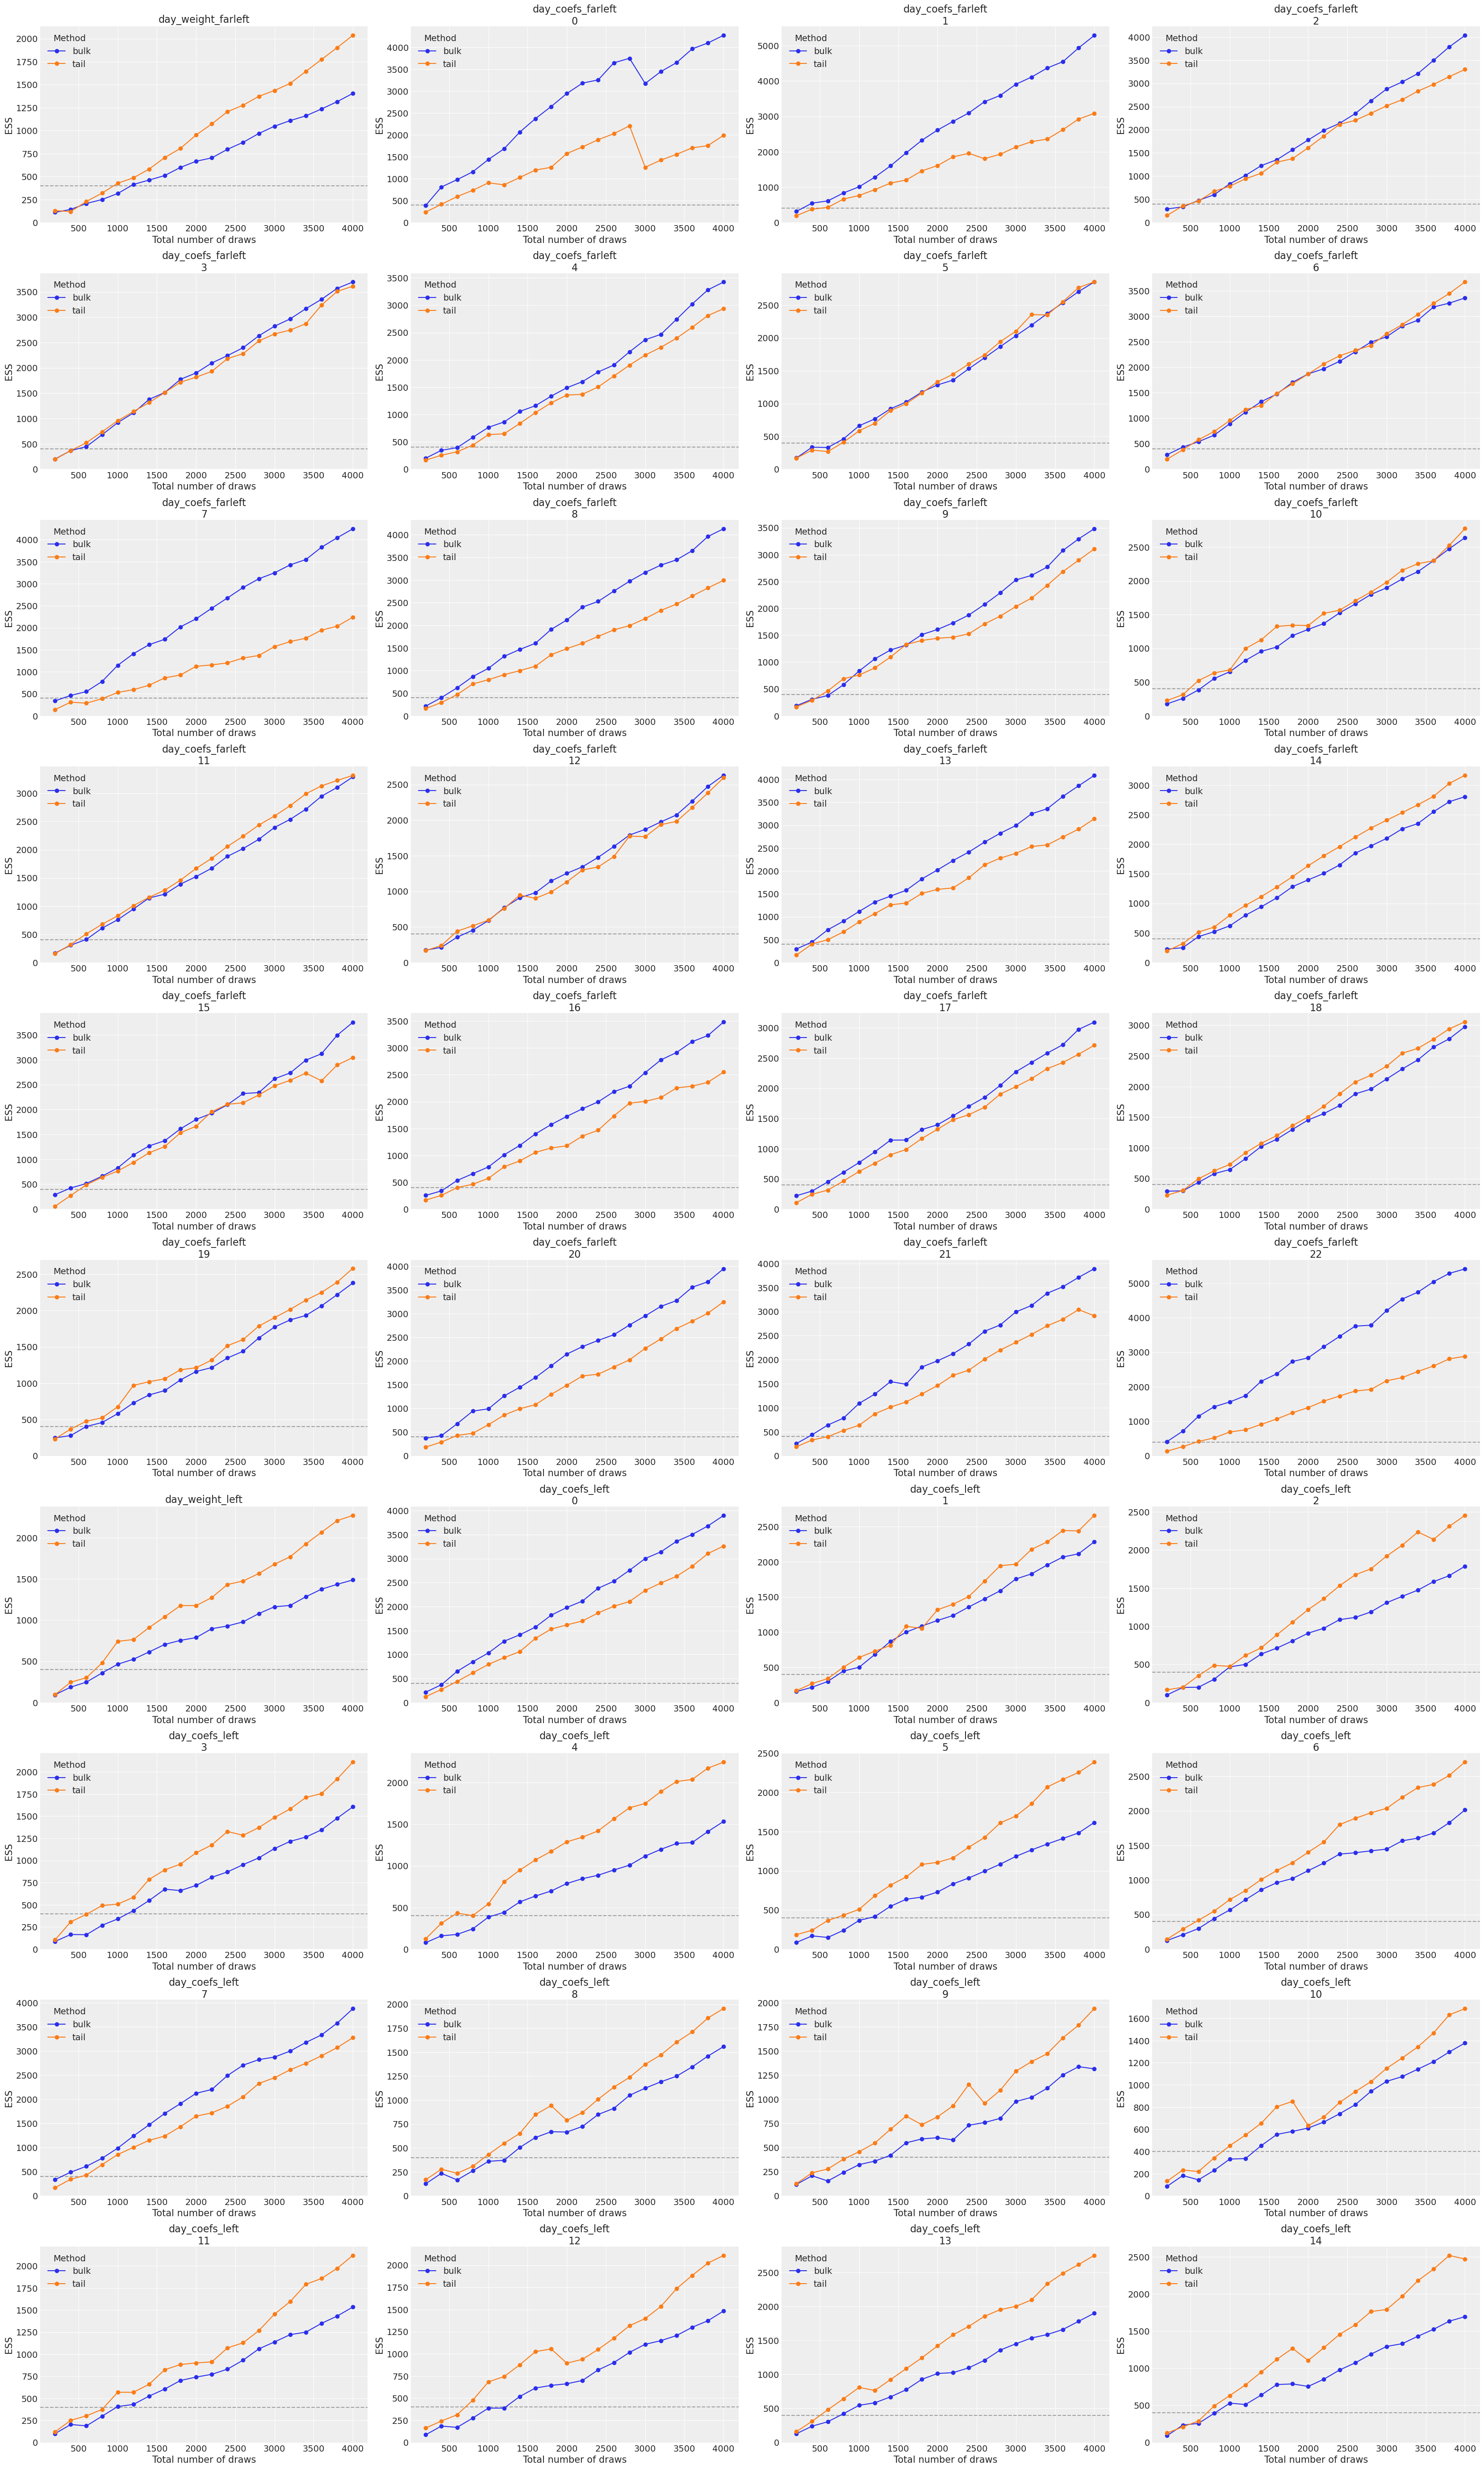

In [104]:
arviz.plot_ess(
    trace_no_trend,
    kind="evolution",
    var_names=["day_weight", "day_coefs"],
    filter_vars="regex",
);

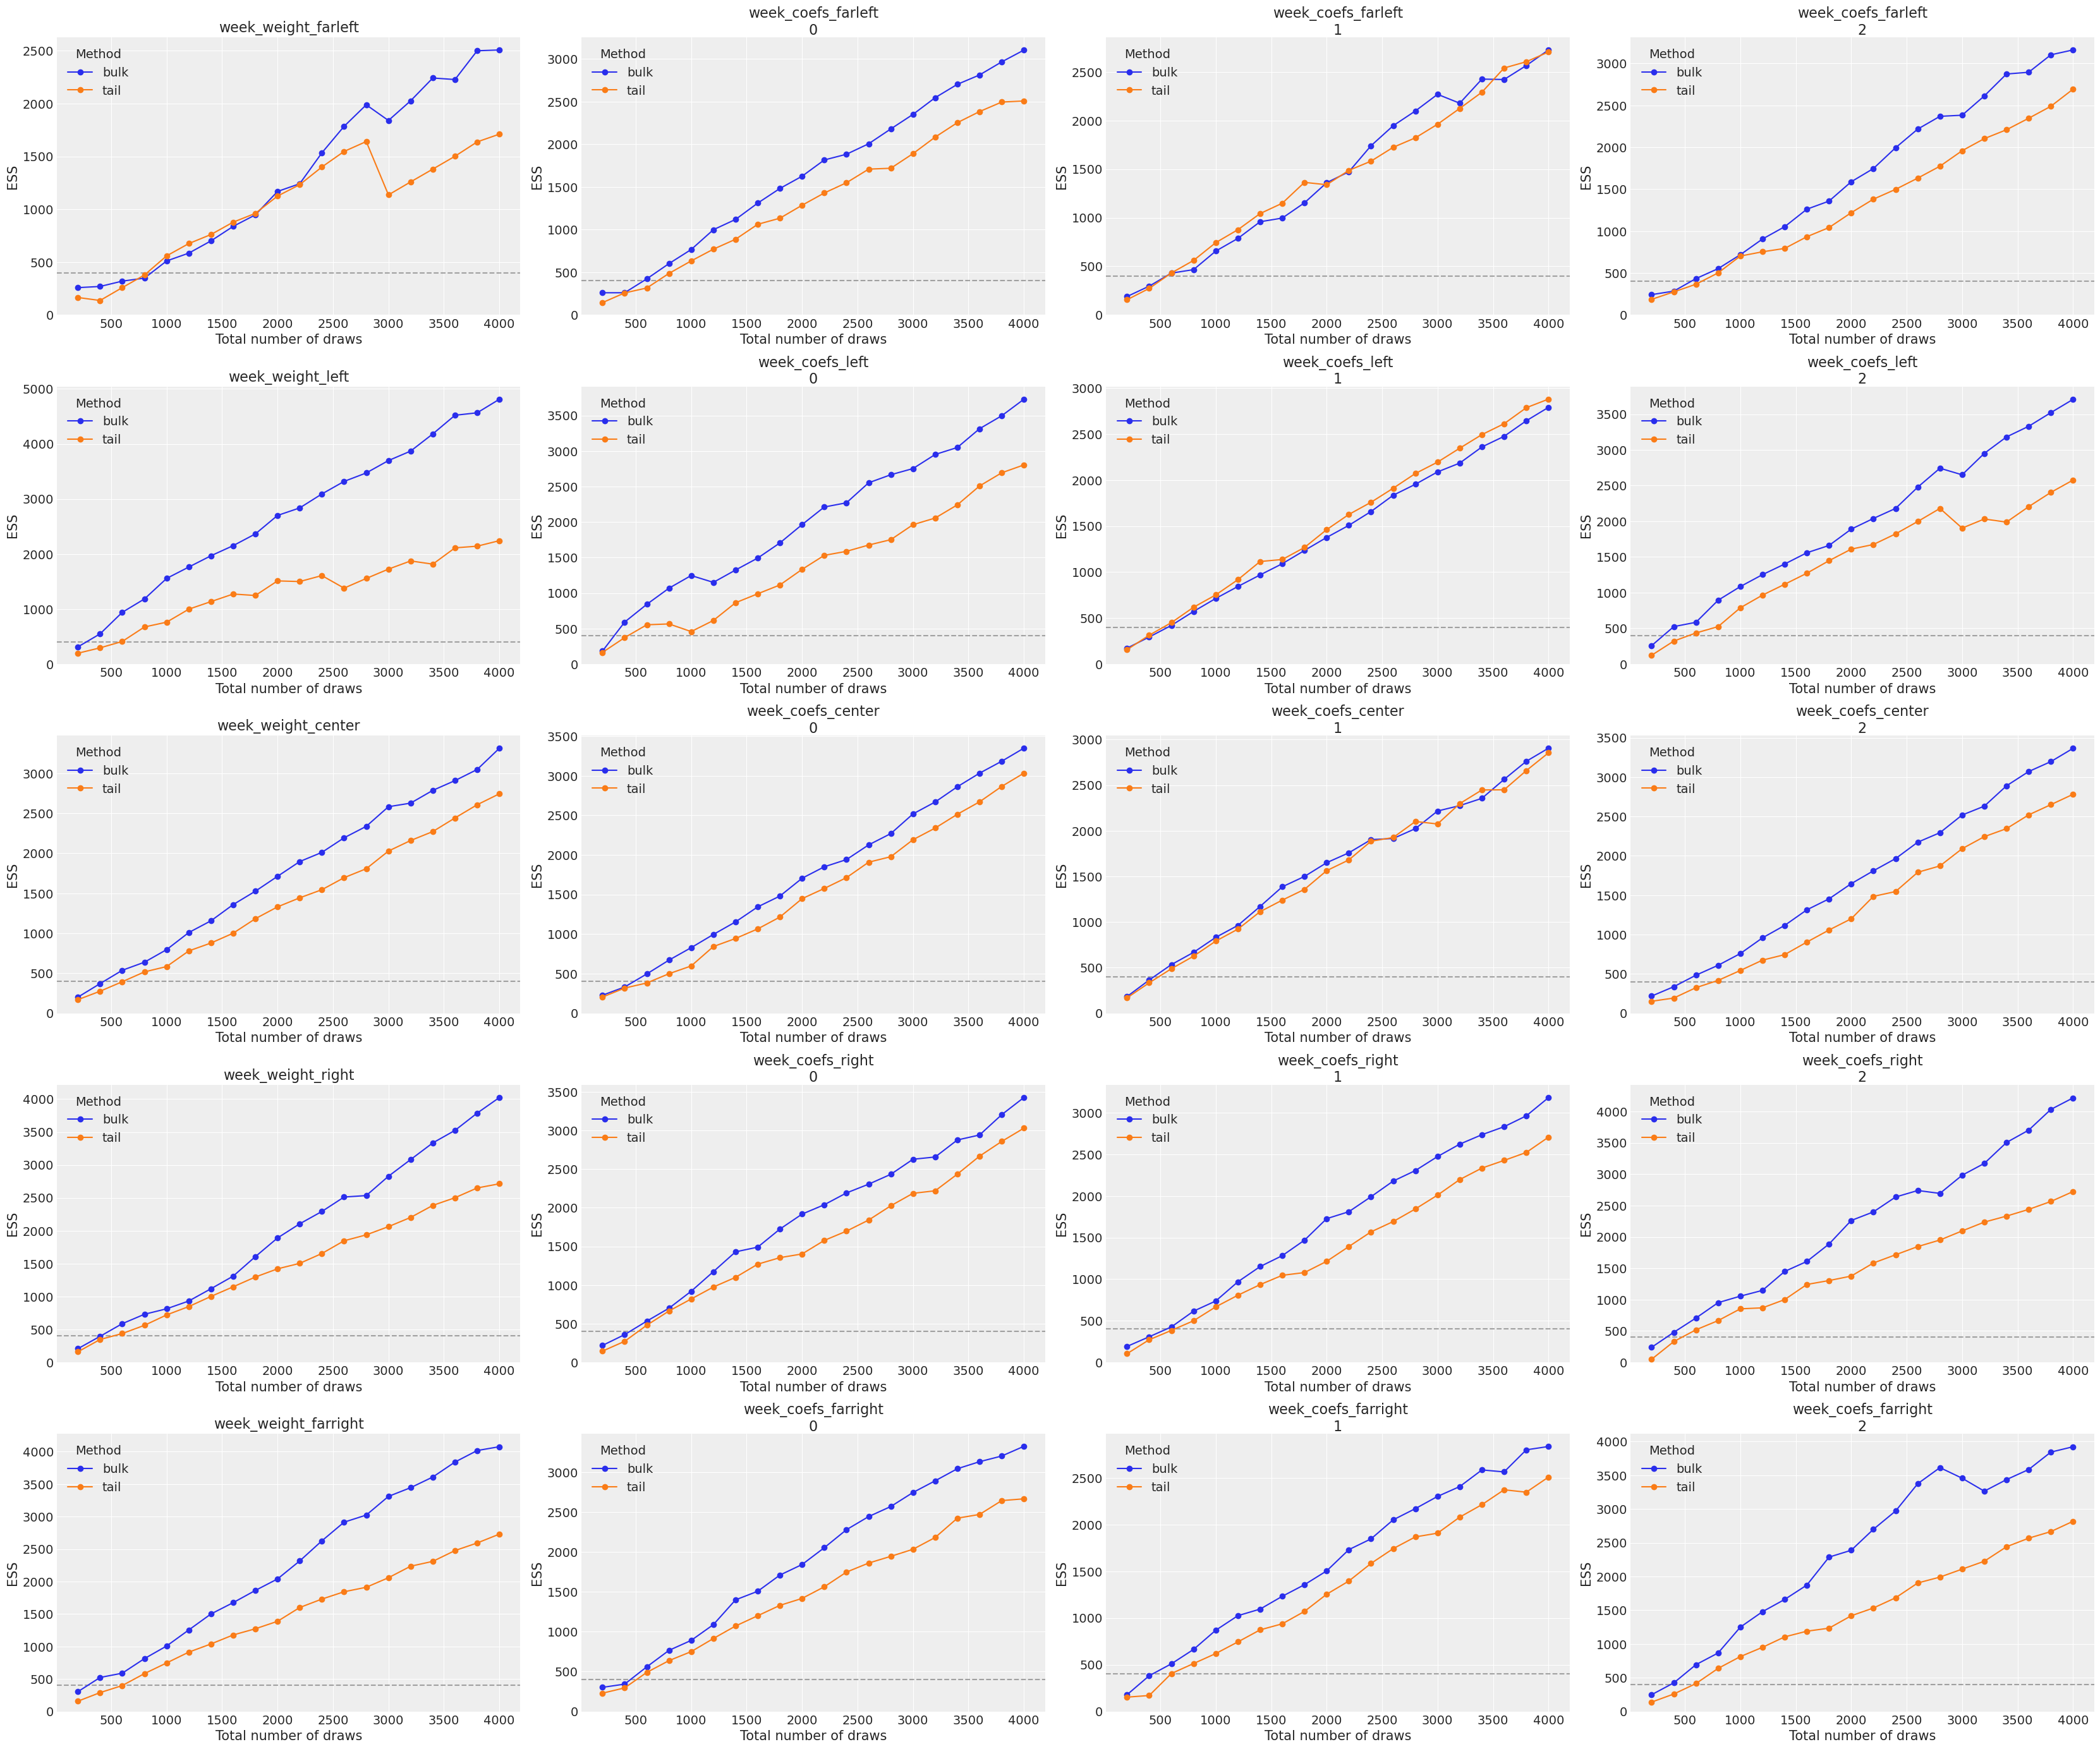

In [105]:
arviz.plot_ess(
    trace_no_trend,
    kind="evolution",
    var_names=["week_weight", "week_coefs"],
    filter_vars="regex",
);

/Users/alex_andorra/opt/anaconda3/envs/pymc3-dev-py39/lib/python3.9/site-packages/arviz/utils.py:124: UserWarning: Items starting with ~: ['_diffs'] have not been found and will be ignored
  warnings.warn(


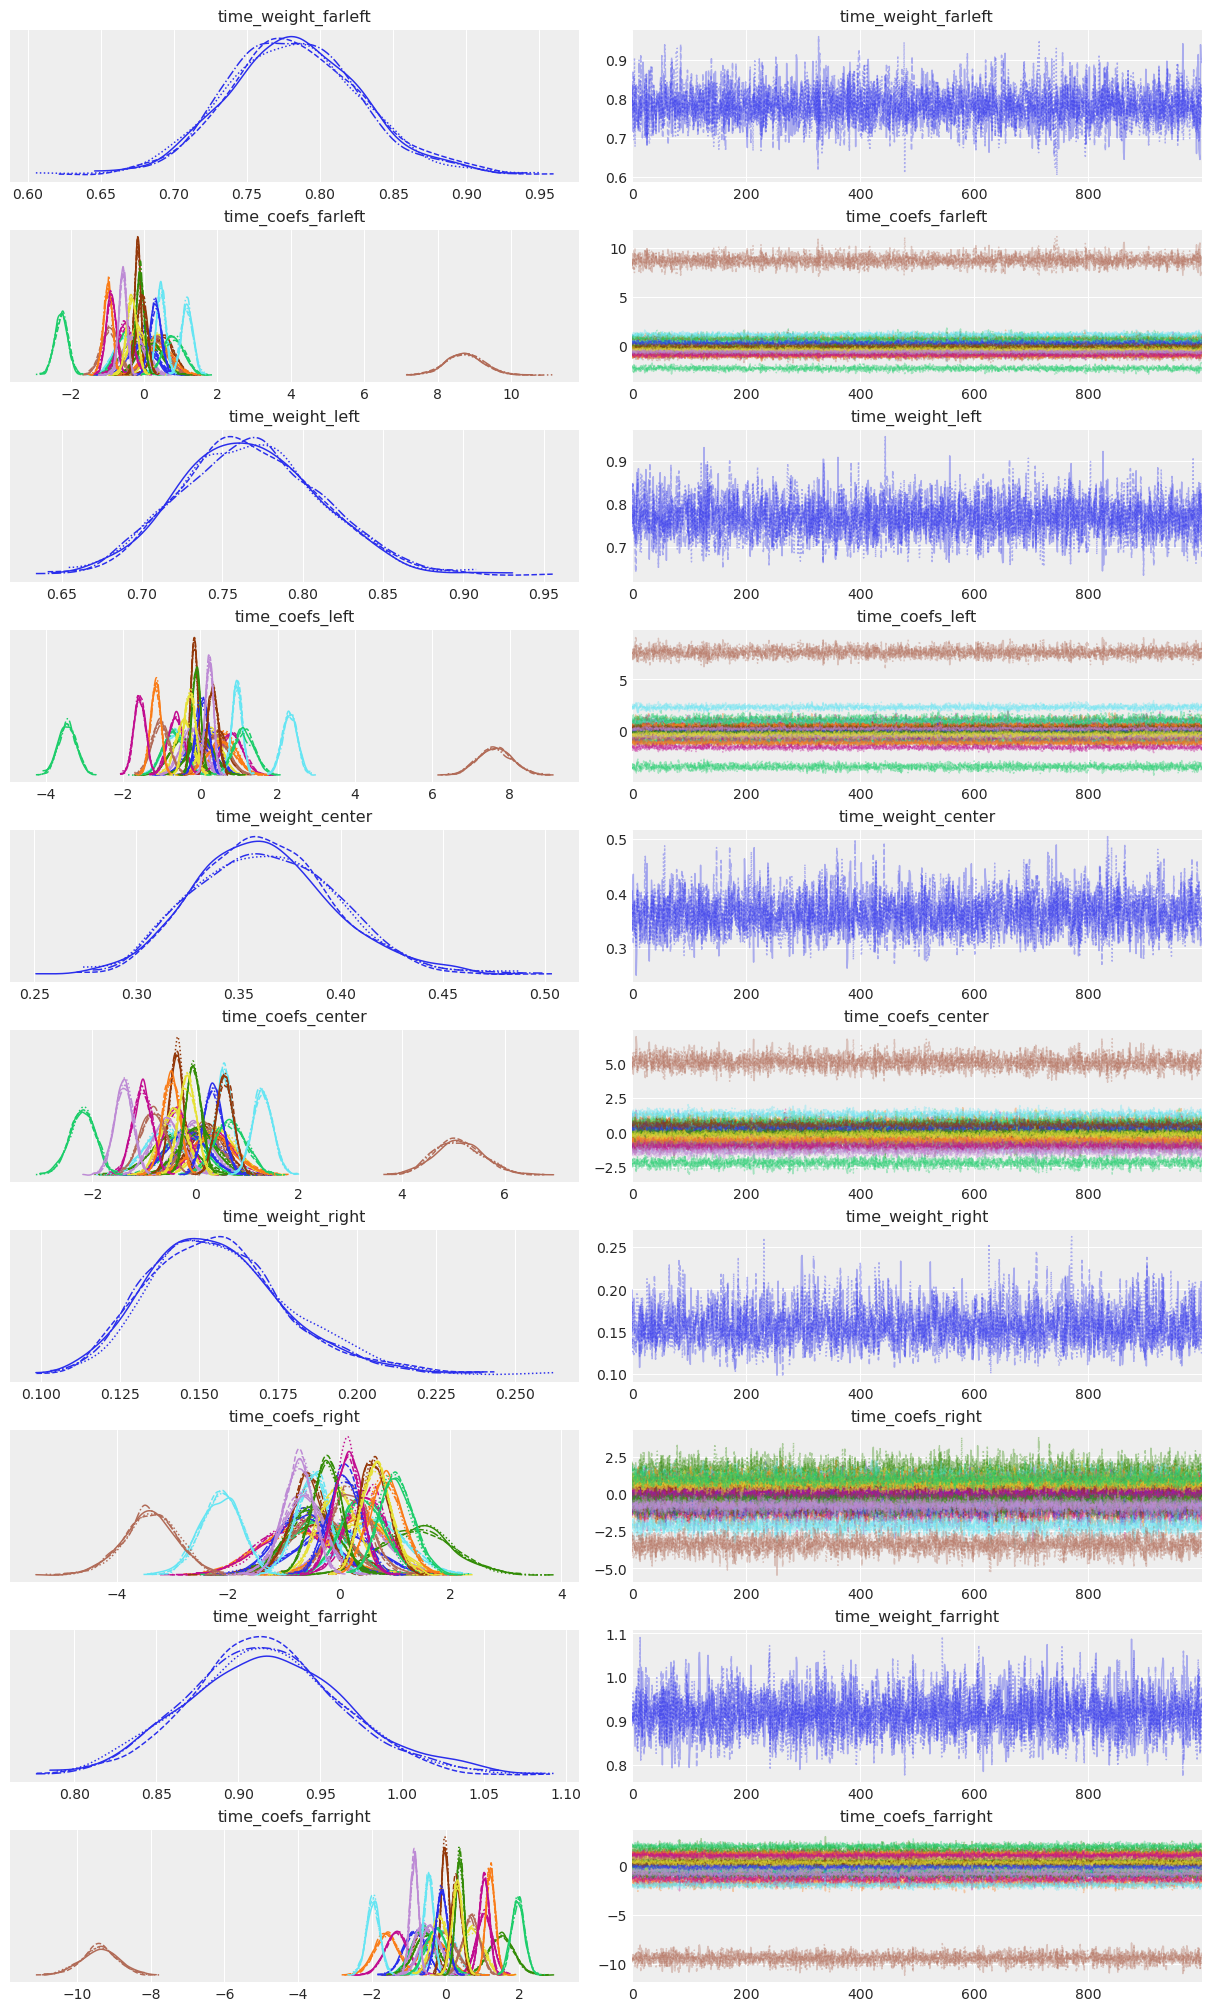

In [82]:
arviz.plot_trace(
    trace_gp,
    var_names=[
        "~ordered_gps",
        "~cutpoints",
        "~_diffs",
        "~_effect",
        "~ordered_",
        "~results_probs",
    ],
    filter_vars="regex",
);

In [43]:
def retrodictive_plot(trace: arviz.InferenceData):
    fig, axes = plt.subplots(4, 2, figsize=(12, 15), sharey=True)
    axes = axes.ravel()
    axes[-1].remove()
    colors = sns.color_palette("rocket", n_colors=7, as_cmap=False)

    post_means = trace.posterior["results_probs"].mean(("chain", "draw"))
    hdi = arviz.hdi(trace.posterior)

    for i, p in enumerate(COORDS["parties_complete"]):
        axes[i].plot(
            polls_train["date"],
            polls_train[p] / polls_train["samplesize"],
            "o",
            color=colors[i],
            alpha=0.4,
        )
        axes[i].fill_between(
            polls_train["date"],
            hdi.sel(parties_complete=p, hdi="lower")["results_probs"],
            hdi.sel(parties_complete=p, hdi="higher")["results_probs"],
            color=colors[i],
            alpha=0.4,
        )
        axes[i].plot(
            polls_train["date"], post_means.sel(parties_complete=p), color=colors[i]
        )
        axes[i].tick_params(axis="x", labelrotation=45, labelsize=10)
        axes[i].set(title=p.title(), ylim=(-0.01, 0.4))

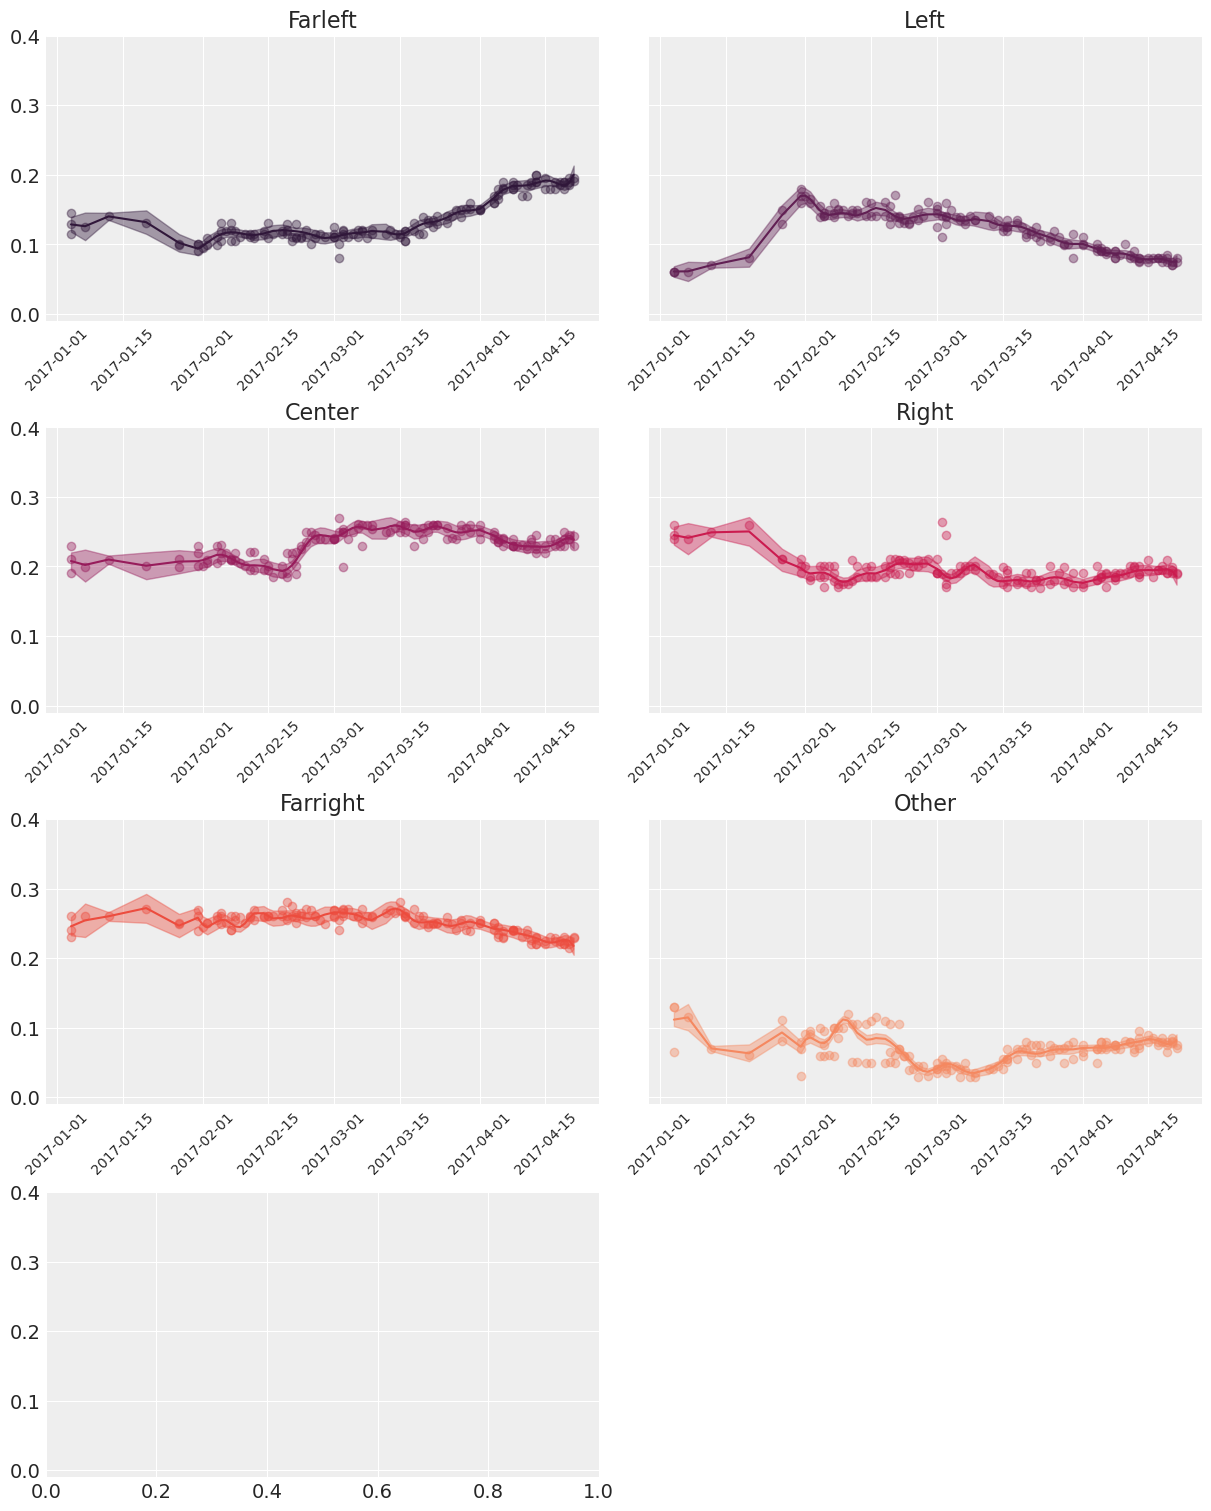

In [83]:
retrodictive_plot(trace_gp)

## Out-of-sample predictions

In [ ]:
trend = pm.Normal("long_term_trends")
t = pm.Data("t", observed_days_idx / observed_days_idx.max(), dims="observations")
eta = pm.Deterministic("eta", trend * t, dims="observations")

In [ ]:
t = pm.Data("t", estimated_days / estimated_days.max(), dims="estimated_days")

cutpoints = pm.Deterministic(
    "cutpoints",
    intercepts + aet.dot(t[:, None], trends[None, :]) + ordered_gps,
    dims=("estimated_days", "parties"),
)

bias = pm.Normal("bias", 0, 0.15, dims="pollsters")

In [46]:
def compute_post_probs(trace: arviz.InferenceData) -> xarray.DataArray:
    p_cum = logistic(trace.posterior["cutpoints"]).data
    # post_eta = np.dot(trace_simple.posterior["long_term_trends"].data[..., None], estimated_days[None, ...])[..., None]
    # p_cum = logistic(trace_simple.posterior["cutpoints"].data - post_eta)
    
    p_cum = np.c_[
        np.zeros_like(p_cum[..., 0][..., None]),
        p_cum,
        np.ones_like(p_cum[..., 0][..., None]),
    ]
    
    return xarray.DataArray(
        p_cum[..., 1:] - p_cum[..., :-1],
        dims=["chain", "draw", "estimated_days", "parties_complete"],
        coords={
            "chain": trace.posterior["chain"],
            "draw": trace.posterior["draw"],
            "estimated_days": trace.posterior["estimated_days"],
            "parties_complete": trace.posterior["parties_complete"],
        },
    )

In [47]:
def predictive_plot(oos_probs: xarray.DataArray):
    fig, axes = plt.subplots(4, 2, figsize=(12, 15), sharey=True)
    axes = axes.ravel()
    axes[-1].remove()
    colors = sns.color_palette("rocket", n_colors=7, as_cmap=False)

    post_means = oos_probs.mean(("chain", "draw"))
    hdi = arviz.hdi(oos_probs)

    for i, p in enumerate(COORDS["parties_complete"]):
        axes[i].plot(
            polls_train["date"],
            polls_train[p] / polls_train["samplesize"],
            "o",
            color=colors[i],
            alpha=0.4,
            label="Observed polls",
        )
        if not polls_test.empty:
            axes[i].plot(
                polls_test["date"],
                polls_test[p] / polls_test["samplesize"],
                "x",
                color="red",
                alpha=0.4,
                label="Unobserved polls",
            )
        axes[i].plot(
            ELECTION_DAY, results[p] / 100, "s", color=colors[i], alpha=0.8, label="Result"
        )
        axes[i].fill_between(
            oos_probs["estimated_days"],
            hdi.sel(parties_complete=p, hdi="lower")["x"],
            hdi.sel(parties_complete=p, hdi="higher")["x"],
            color=colors[i],
            alpha=0.4,
        )
        axes[i].plot(
            oos_probs["estimated_days"],
            post_means.sel(parties_complete=p),
            color=colors[i],
        )
        axes[i].axvline(
            x=TEST_CUTOFF,
            ymin=-0.01,
            ymax=1.0,
            ls="--",
            c="k",
            alpha=0.4,
            label="Test cutoff",
        )
        axes[i].axvline(
            x=ELECTION_DAY,
            ymin=-0.01,
            ymax=1.0,
            ls=":",
            c="k",
            alpha=0.4,
            label="Election Day",
        )
        axes[i].tick_params(axis="x", labelrotation=45, labelsize=10)
        axes[i].set(title=p.title(), ylim=(-0.01, 0.4))
        axes[i].legend(fontsize=10, ncol=3)

In [84]:
post_probs = compute_post_probs(trace_gp)

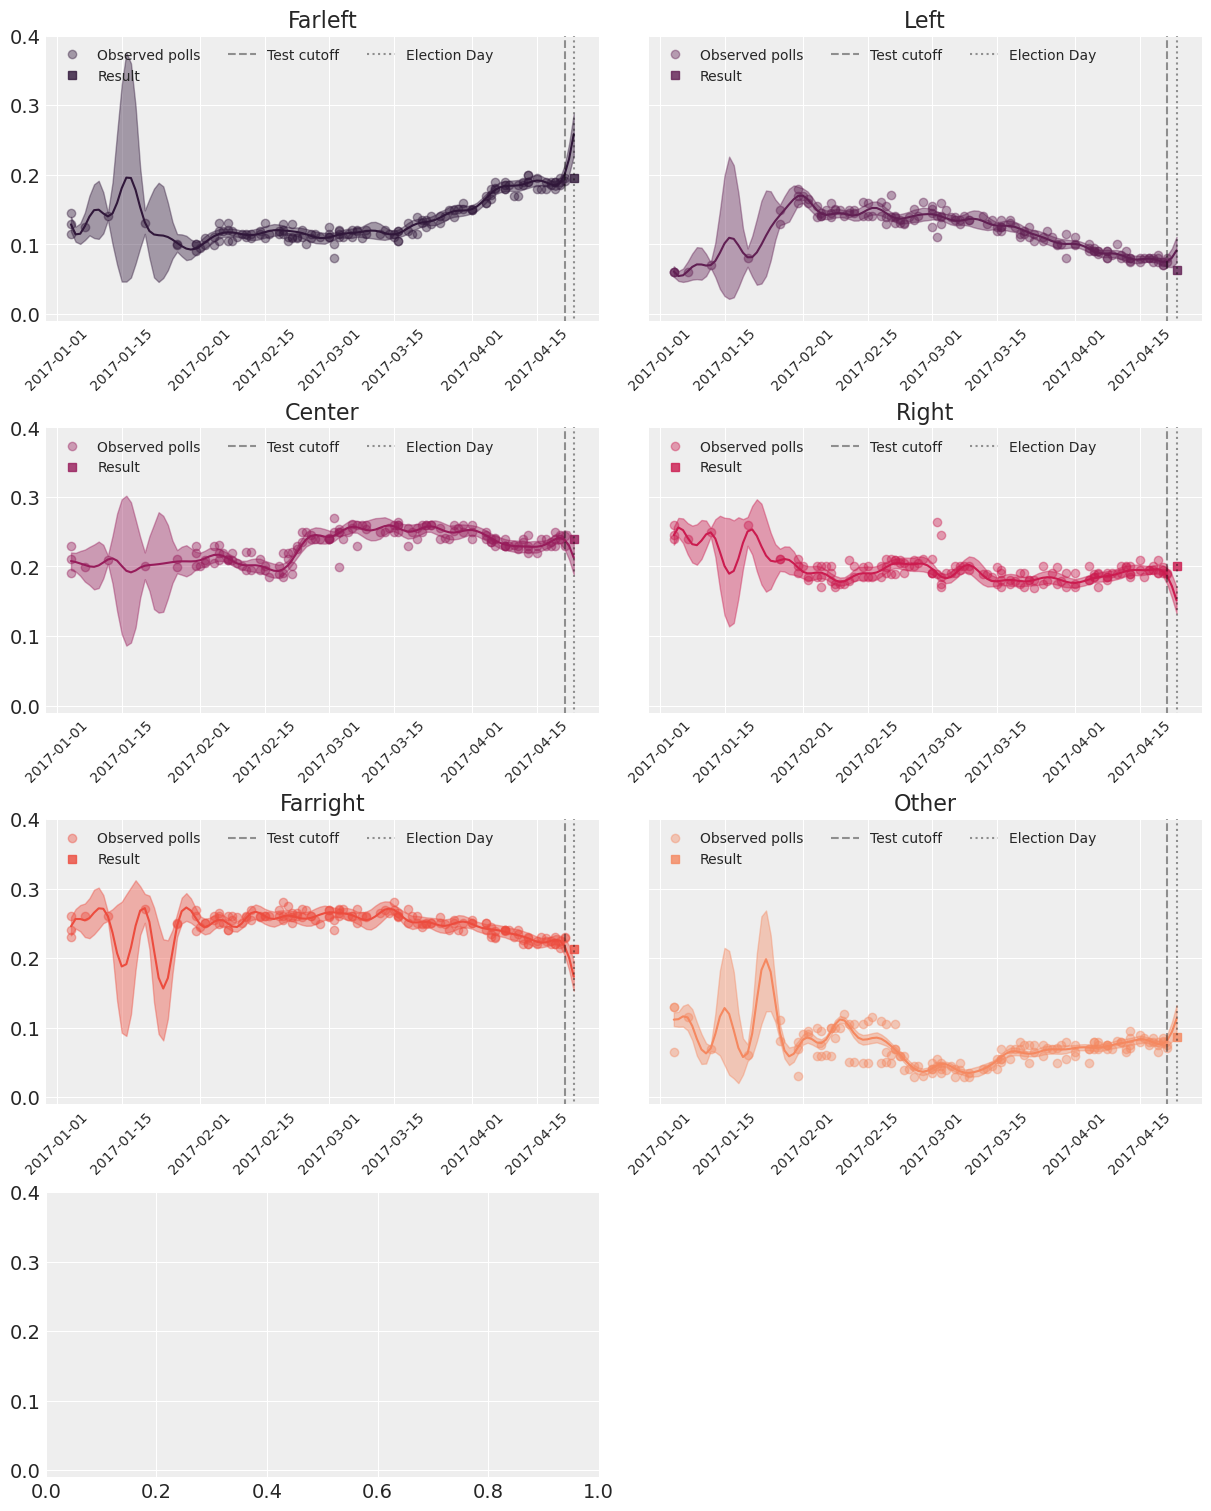

In [85]:
predictive_plot(post_probs)

In [ ]:
# read theory about ordinal regression
# prior pred checks
# biases ZeroSum
# overdispersion
# add popularity as predictor. And an econ variable?
# plain multinomial?